# Random Forests == Awesome

Random Forests should be the hammer of your data science tool kit. 

What are they?
* Machine learning algorithm built for prediction tasks

Pros
* Automatically model non-linear relations and interactions between variables. Perfect collinearity doesn't matter.
* Easy to tune
* Relatively easy to understand everything about them
* Flexible enough to handle regression and classification tasks
* Is useful as a step in exploratory data analysis
* Can handle high dimensional data
* Have a built in method of checking to see model accuracy
* In general, beats most models at most prediction tasks

Cons
* ?
* ?
* ?

# Simple example: Boston Housing dataset

In [1]:
%matplotlib inline

In [2]:
# Load the Boston Housing dataset
from sklearn.datasets import load_boston
X, y = load_boston().data, load_boston().target

# Make train and test datasets
from sklearn.cross_validation import train_test_split
import numpy as np
np.random.seed(100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [3]:
X.shape

(506, 13)

### Linear Regression

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
print ("R^2:", model.score(X_test, y_test).round(2))

R^2: 0.76


### Decision Tree

In [5]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X_train, y_train)
print ("R^2:", model.score(X_test, y_test).round(2))

R^2: 0.8


### Random Forest with defaults

In [6]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
print ("R^2:", model.score(X_test, y_test).round(2))

R^2: 0.87


## Prerequisites
* Decision trees
* Bootstrap sampling

## The Random Forest Algorithm

The big idea: Combine a bunch of terrible decision trees into one awesome model. 

For each tree in the forest:
1. Take a bootstrap sample of the data
2. Randomly select some variables.
3. For each variable selected, find the split point which minimizes MSE (or Gini Impurity or Information Gain if classification).
4. Split the data using the variable with the lowest MSE (or other stat).
5. Repeat step 2 through 4 (randomly selecting new sets of variables at each split) until some stopping condition is satisfied or all the data is exhausted.

Repeat this process to build several trees. 

To make a prediction, run an observation down several trees and average the predicted values from all the trees (for regression) or find the most popular class predicted (if classification).

##Most important parameters (and what they mean)
 * ###Parameters that will make your model better
  * <b>n_estimators</b>: The number of trees in the forest. Choose as high of a number as your computer can handle.
  * <b>max_features</b>: The number of features to consider when looking for the best split. Try ["auto", "None", "sqrt", "log2", 0.9, and 0.2]
  * <b>min_samples_leaf</b>: The minimum number of samples in newly created leaves.Try [1, 2, 3]. If 3 is the best, try higher numbers.
 * ###Parameters that will make it easier to train your model
  * <b>n_jobs</b>: Determines if multiple processors should be used to train and test the model. Always set this to -1 and %%timeit vs. if it is set to 1. It should be much faster (especially when many trees are trained).
  * <b>random_state</b>: Set this to 42 if you want to be cool AND want others to be able to replicate your results.
  * <b>oob_score</b>: THE BEST THING EVER. Random Forest's custom validation method: out-of-bag predictions.

## OOB predictions
About a third of observations don't show up in a bootstrap sample. 

Because an individual tree in the forest is made from a bootstrap sample, it means that about a third of the data was not used to build that tree. We can track which observations were used to build which trees.

#### Here is the magic. 

After the forest is built, we take each observation in the dataset and identify which trees used the observation and which trees did not use the observation (based on the bootstrap sample). We use the trees the observation was not used to build to predict the true value of the observation. About a third of the trees in the forest will not use any specific observation from the dataset. 

OOB predictions are similar to following awesome, but computationally expensive method: 
1. Train a model with n_estimators trees, but exclude one observation from the dataset.
2. Use the trained model to predict the excluded observation. Record the prediction.
3. Repeat this process for every single observation in the dataset.
4. Collect all your final predictions. These will be similar to your oob prediction errors. 

The leave-one-out method will take n_estimators\*time_to_train_one_model\*n_observations to run. 

The oob method will take n_estimators\*time_to_train_one_model\*3 to run (the \*3 is because if you want to get an accuracy estimate of a 100 tree forest, you will need to train 300 trees. Why? Because with 300 trees each observation will have about 100 trees it was not used to build that can be used for the oob_predictions).

This means the oob method is n_observations/3 times faster to train then the leave-one-out method.

## Full example. Titanic dataset

###Your first goal always should be getting a generalized prediction as fast as possible.
* This doesn't mean to skip exploratory data analysis (EDA). It just means to not get caught up on it. Initially do only what is needed to get a generalized prediction.
* Getting a prediction first lets you set a benchmark for yourself. As you make improvements to the model, you should be able to see your desired error metric improve.

In [1]:
# With the goal above, I will import just what I need. 
# The model to use (I already imported it above, but will do it again here so each example is self-contained)
from sklearn.ensemble import RandomForestRegressor

# The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score

# An efficient data structure. 
import pandas as pd

# Import the data
X = pd.read_csv("titanic_train.csv")
y = X.pop("Survived")

In [2]:
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


I know that there are categorical variables in the dataset, but I will skip them for the moment. I will impute age though, because it will be fast.

In [3]:
# Impute Age with mean
X["Age"].fillna(X.Age.mean(), inplace=True)

# Confirm the code is correct
X.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,13.002015,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# Get just the numeric variables by selecting only the variables that are not "object" datatypes.
numeric_variables = list(X.dtypes[X.dtypes != "object"].index)
X[numeric_variables].head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500


I notice PassengerId looks like a worthless variable. I leave it in for two reasons. First, I don't want to go through the effort of dropping it (although that would be very easy). Second, I am interested in seeing if it is useful for prediction. It might be useful if the PassengerId was assigned in some non-random way. For example, perhaps PassengerId was assigned based on when the ticket was purchased in which case there might be something predictive about people who purchased their tickets early or late.

In [5]:
# Let's build our first model. I always have oob_score=True. It is a good idea to increase n_estimators to a number higher than 
# the default. In this case the oob_predictions will be based on a forest of 33 trees. I set random_state=42 so that you all can
# replicate the model exactly.
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

# I only use numeric_variables because I have yet to dummy out the categorical variables
model.fit(X[numeric_variables], y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [6]:
# For regression, the oob_score_ attribute gives the R^2 based on the oob predictions. We want to use c-stat, but I mention this 
# for awareness. By the way, attributes in sklearn that have a trailing underscore are only available after the model has been fit.
model.oob_score_

0.1361695005913669

In [7]:
y_oob = model.oob_prediction_
print("c-stat: ", roc_auc_score(y, y_oob))

c-stat:  0.7399551550399983


We now have a benchmark. This isn't very good for this dataset; however, it provides us a benchmark for improvement. Before changing parameters for the Random Forest, let's whip this dataset into shape.

In [8]:
# Here is a simple function to show descriptive stats on the categorical variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "object"]].describe().to_html()))

In [9]:
describe_categorical(X)

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Romaine, Mr. Charles Hallace (""Mr C Rolmane"")",male,CA. 2343,G6,S
freq,1,577,7,4,644


In [10]:
# Drop the variables I don't feel like dealing with for this tutorial
X.drop(["Name", "Ticket", "PassengerId"], axis=1, inplace=True)

In [11]:
# Change the Cabin variable to be only the first letter or None
def clean_cabin(x):
    try:
        return x[0]
    except TypeError:
        return "None"

X["Cabin"] = X.Cabin.apply(clean_cabin)

In [12]:
categorical_variables = ['Sex', 'Cabin', 'Embarked']

for variable in categorical_variables:
    # Fill missing data with the word "Missing"
    X[variable].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(X[variable], prefix=variable)
    # Update X to include dummies and drop the main variable
    X = pd.concat([X, dummies], axis=1)
    X.drop([variable], axis=1, inplace=True)

In [13]:
X

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
5,3,29.699118,0,0,8.4583,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
6,1,54.000000,0,0,51.8625,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1
7,3,2.000000,3,1,21.0750,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
8,3,27.000000,0,2,11.1333,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
9,2,14.000000,1,0,30.0708,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0


In [14]:
# Look at all the columns in the dataset
def printall(X, max_rows=10):
    from IPython.display import display, HTML
    display(HTML(X.to_html(max_rows=max_rows)))
    
printall(X)

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_None,Cabin_T,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,3,22.000000,1,0,7.2500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
1,1,38.000000,1,0,71.2833,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0
2,3,26.000000,0,0,7.9250,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,1,35.000000,1,0,53.1000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,3,35.000000,0,0,8.0500,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,27.000000,0,0,13.0000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
887,1,19.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
888,3,29.699118,1,2,23.4500,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1
889,1,26.000000,0,0,30.0000,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0


In [15]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print ("C-stat: ", roc_auc_score(y, model.oob_prediction_))

C-stat:  0.8635211282608464


This is a pretty good model. Now, before we try some different parameters for the model, let's use the Random Forest to help us with some EDA.

### Variable importance measures

In [16]:
model.feature_importances_

array([9.11384671e-02, 2.38891052e-01, 4.43567267e-02, 2.15831071e-02,
       2.15047796e-01, 1.43423437e-01, 1.58822440e-01, 2.95342368e-03,
       3.79055011e-03, 6.47116172e-03, 4.30998991e-03, 8.59480266e-03,
       1.02403226e-03, 8.12054428e-04, 2.67741854e-02, 6.64265010e-05,
       1.06189189e-02, 0.00000000e+00, 6.00379221e-03, 1.53176370e-02])

In [17]:
# Simple version that shows all of the variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(7,6));

In [18]:
# Complex version that shows the summary view

def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.05, width=10, summarized_columns=None):
    """
    By Mike Bernico
    
    Graphs the feature importances of a random decision forest using a horizontal bar chart. 
    Probably works but untested on other sklearn.ensembles.
    
    Parameters
    ----------
    ensemble = Name of the ensemble whose features you would like graphed.
    feature_names = A list of the names of those featurs, displayed on the Y axis.
    autoscale = True (Automatically adjust the X axis size to the largest feature +.headroom) / False = scale from 0 to 1
    headroom = used with autoscale, .05 default
    width=figure width in inches
    summarized_columns = a list of column prefixes to summarize on, for dummy variables (e.g. ["day_"] would summarize all day_ vars
    """
    
    if autoscale:
        x_scale = model.feature_importances_.max()+ headroom
    else:
        x_scale = 1
    
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    
    if summarized_columns: 
        #some dummy columns need to be summarized
        for col_name in summarized_columns: 
            #sum all the features that contain col_name, store in temp sum_value
            sum_value = sum(x for i, x in feature_dict.items() if col_name in i )  
            
            #now remove all keys that are part of col_name
            keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
            for i in keys_to_remove:
                feature_dict.pop(i)
            #lastly, read the summarized field
            feature_dict[col_name] = sum_value
        
    results = pd.Series(feature_dict)
    results.sort_values(inplace=True)
    results.plot(kind="barh", figsize=(width,len(results)/4), xlim=(0,x_scale))
    
graph_feature_importances(model, X.columns, summarized_columns=categorical_variables)

## Parameter tests

Parameters to test

 * ###Parameters that will make your model better
  * <b>n_estimators</b>: The number of trees in the forest. Choose as high of a number as your computer can handle.
  * <b>max_features</b>: The number of features to consider when looking for the best split. Try ["auto", "None", "sqrt", "log2", 0.9, and 0.2]
  * <b>min_samples_leaf</b>: The minimum number of samples in newly created leaves.Try [1, 2, 3]. If 3 is the best, try higher numbers such as 1 through 10.
 * ###Parameters that will make it easier to train your model
  * <b>n_jobs</b>: Determines if multiple processors should be used to train and test the model. Always set this to -1 and %%timeit vs. if it is set to 1. It should be much faster (especially when many trees are trained).

### n_jobs

In [25]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 1.21 s per loop


In [26]:
%%timeit
model = RandomForestRegressor(1000, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)

1 loop, best of 3: 708 ms per loop


### n_estimators

30 trees
C-stat:  0.853875733657

50 trees
C-stat:  0.860698345743

100 trees
C-stat:  0.863521128261

200 trees
C-stat:  0.862192290076

500 trees
C-stat:  0.863739494456

1000 trees
C-stat:  0.864043076726

2000 trees
C-stat:  0.863449227197



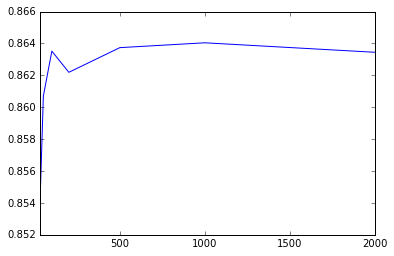

In [27]:
results = []
n_estimator_options = [30, 50, 100, 200, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X, y)
    print (trees, "trees")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, n_estimator_options).plot();

### max_features

auto option
C-stat:  0.864043076726

None option
C-stat:  0.864043076726

sqrt option
C-stat:  0.86337466313

log2 option
C-stat:  0.86337466313

0.9 option
C-stat:  0.863534443273

0.2 option
C-stat:  0.86337466313



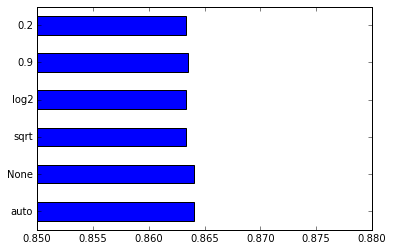

In [28]:
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X, y)
    print (max_features, "option")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.85,.88));

### min_samples_leaf

1 min samples
C-stat:  0.864043076726

2 min samples
C-stat:  0.869654022731

3 min samples
C-stat:  0.871571384442

4 min samples
C-stat:  0.873478094142

5 min samples
C-stat:  0.874269005848

6 min samples
C-stat:  0.874029335634

7 min samples
C-stat:  0.873304998988

8 min samples
C-stat:  0.871866977705

9 min samples
C-stat:  0.869294517411

10 min samples
C-stat:  0.867430415748



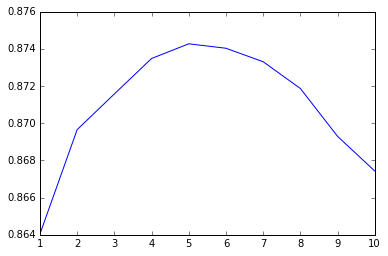

In [29]:
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=1000, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    model.fit(X, y)
    print (min_samples, "min samples")
    roc = roc_auc_score(y, model.oob_prediction_)
    print ("C-stat: ", roc)
    results.append(roc)
    print ("")
    
pd.Series(results, min_samples_leaf_options).plot();

## Final model

In [30]:
model = RandomForestRegressor(n_estimators=1000, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features="auto", 
                              min_samples_leaf=5)
model.fit(X, y)
roc = roc_auc_score(y, model.oob_prediction_)
print ("C-stat: ", roc)

C-stat:  0.874269005848
